In [30]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

## Load and prepare data

In [32]:
# forest loss data
df_forest = pd.read_csv('Data/district_forest_cover.csv')

# SPEI growing period data
df_spei = pd.read_csv('Data/district_province_spei_growingperiod.csv')

# rename season_year column in SPEI df
df_spei = df_spei.rename(columns={'season_year': 'year'})

# population data
df_pop = pd.read_csv('Data/district_pop_growth.csv')

# clean columns
df_pop = df_pop.drop(columns=['Unnamed: 0'])

for df in [df_forest, df_pop, df_spei]:
    df['district'] = df['district'].str.strip().str.title()

# calculate population density
# load district shapefile
districts_gdf = gpd.read_file('Data/district.shp')

# set CRS
districts_gdf = districts_gdf.set_crs(epsg=4326)

# reproject to a metric CRS
districts_gdf = districts_gdf.to_crs(epsg=32735)

# compute area (square kilometers)
districts_gdf['district_area_km2'] = districts_gdf['geometry'].area / 1e6

# standardize district names
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()
df_pop['district'] = df_pop['district'].str.strip().str.title()

# drop geometry
area_df = districts_gdf[['district', 'district_area_km2']]

# merge with population
df_pop = df_pop.merge(area_df, on='district', how='left')

# calculate population density
df_pop['pop_density'] = df_pop['population'] / df_pop['district_area_km2']

merged = (df_forest
          .merge(df_pop,  on=['district', 'year'], how='outer')
          .merge(df_spei, on=['district', 'year'], how='outer'))

# calculate percent forest cover in 2000
merged['percent_forest_2000'] = (merged['forest_2000_m2'] / merged['district_area_km2']) * 100

# compute SPEI lags
merged = merged.sort_values(['district', 'year'])
for lag in range(1, 6):
    merged[f'mean_spei_lag{lag}'] = (
        merged.groupby('district')['mean_growing_spei'].shift(lag)
    )

model_vars = ['percent_loss_annual', 'mean_spei_lag4',
              'pop_density', 'percent_forest_2000']

cleaned = merged[
    (merged['year'].between(2001, 2020)) & 
    merged[model_vars].notna().all(axis=1)
].copy()

# center population density
cleaned['pop_density_c'] = cleaned['pop_density'] - cleaned['pop_density'].mean()

# scale population density
cleaned['pop_density_c_scaled'] = cleaned['pop_density_c'] / 100

# within-district centering to isolate changes over time
cleaned['pop_density_wi'] = (
    cleaned['pop_density_c_scaled'] -
    cleaned.groupby('district')['pop_density_c_scaled'].transform('mean')
)

# create interaction term
cleaned['spei4_x_popdens'] = cleaned['mean_spei_lag4'] * cleaned['pop_density_wi']
    
cleaned.head()

,district,year,forest_cover_ha,loss_m2,percent_loss_annual,forest_2000_m2,population,pop_growth,district_area_km2,pop_density,...,percent_forest_2000,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5,pop_density_c,pop_density_c_scaled,pop_density_wi,spei4_x_popdens
4,Chadiza,2004,56773.795452,1.871819e+06,0.328614,5.723238e+08,66126.242188,0.018467,1518.283564,43.553289,...,3.769545e+07,0.227219,0.281255,0.364988,0.841021,NaN,-71.431376,-0.714314,-0.066837,-0.056211
5,Chadiza,2005,56703.324923,7.047053e+05,0.124125,5.723238e+08,67476.906250,0.020426,1518.283564,44.442888,...,3.769545e+07,-0.079997,0.227219,0.281255,0.364988,0.841021,-70.541777,-0.705418,-0.057941,-0.021148
6,Chadiza,2006,56388.063193,3.152617e+06,0.555985,5.723238e+08,68212.812500,0.010906,1518.283564,44.927584,...,3.769545e+07,-0.699067,-0.079997,0.227219,0.281255,0.364988,-70.057080,-0.700571,-0.053094,-0.014933
7,Chadiza,2007,56253.107717,1.349555e+06,0.239333,5.723238e+08,68965.882812,0.011040,1518.283564,45.423585,...,3.769545e+07,0.170735,-0.699067,-0.079997,0.227219,0.281255,-69.561079,-0.695611,-0.048134,-0.010937
8,Chadiza,2008,55860.402357,3.927054e+06,0.698104,5.723238e+08,71330.296875,0.034284,1518.283564,46.980879,...,3.769545e+07,0.760298,0.170735,-0.699067,-0.079997,0.227219,-68.003785,-0.680038,-0.032561,0.002605


## Regression model

In [33]:
# log-transformed outcome
cleaned['log_percent_loss'] = np.log1p(cleaned['percent_loss_annual'])

model_log = smf.ols(
    'log_percent_loss ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

coefs = model_log.summary2().tables[1]

# filter rows that correspond to districts
district_rows = coefs[coefs.index.str.startswith('C(district)')]

# filter for statistically significant districts
significant_districts = district_rows[district_rows['P>|t|'] < 0.05].copy()

# extract the district names
significant_districts['district'] = (
    significant_districts.index
    .str.split('T.').str[-1]   
    .str.rstrip(']')            
)

# convert to list of names
significant_district_list = significant_districts['district'].tolist()

#html_summary = model_log.summary().as_html()

#with open('regression_summary.html', 'w') as f:
    #f.write(html_summary)

                            OLS Regression Results                            
Dep. Variable:       log_percent_loss   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     11.35
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           4.29e-89
Time:                        11:52:02   Log-Likelihood:                -287.89
No. Observations:                1173   AIC:                             719.8
Df Residuals:                    1101   BIC:                             1085.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

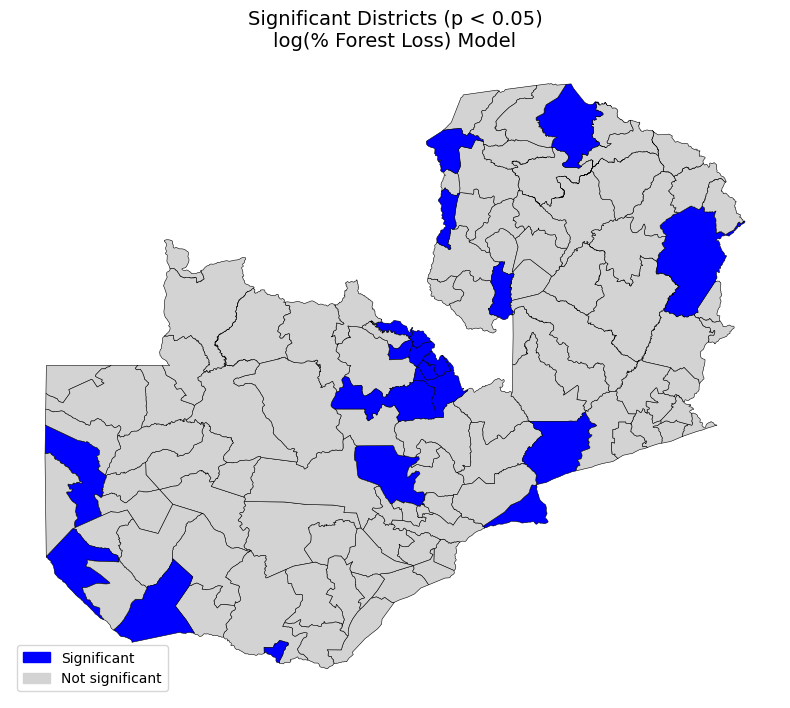

In [34]:
# map significant districts
districts_gdf = gpd.read_file('Data/district.shp')

# standardize district name
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()

# mark significant districts
districts_gdf['significant'] = districts_gdf['district'].isin(significant_district_list)

# create color column for plotting
districts_gdf['color'] = districts_gdf['significant'].map({True: 'blue', False: 'lightgray'})

# plot
fig, ax = plt.subplots(figsize=(8, 10))
districts_gdf.plot(ax=ax, color=districts_gdf['color'], edgecolor='black', linewidth=0.4)

ax.set_title("Significant Districts (p < 0.05)\nlog(% Forest Loss) Model", fontsize=14)
ax.axis("off")

# Legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='blue', label='Significant'),
    mpatches.Patch(color='lightgray', label='Not significant')
]
ax.legend(handles=legend_handles, loc='lower left')

plt.tight_layout()
plt.show()

In [36]:
# log-transformed outcome
cleaned['log_loss_m2'] = np.log1p(cleaned['loss_m2'])

model_log = smf.ols(
    'log_loss_m2 ~ mean_spei_lag4 + pop_density_wi + spei4_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

coefs = model_log.summary2().tables[1]

# filter rows that correspond to districts
district_rows = coefs[coefs.index.str.startswith('C(district)')]

# filter for statistically significant districts
significant_districts = district_rows[district_rows['P>|t|'] < 0.05].copy()

# extract the district names
significant_districts['district'] = (
    significant_districts.index
    .str.split('T.').str[-1]   
    .str.rstrip(']')            
)

# convert to list of names
significant_district_list = significant_districts['district'].tolist()

html_summary = model_log.summary().as_html()

with open('m2_regression_summary.html', 'w') as f:
    f.write(html_summary)

                            OLS Regression Results                            
Dep. Variable:            log_loss_m2   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     49.32
Date:                Fri, 27 Jun 2025   Prob (F-statistic):          5.01e-291
Time:                        11:58:26   Log-Likelihood:                -1877.3
No. Observations:                1173   AIC:                             3899.
Df Residuals:                    1101   BIC:                             4264.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

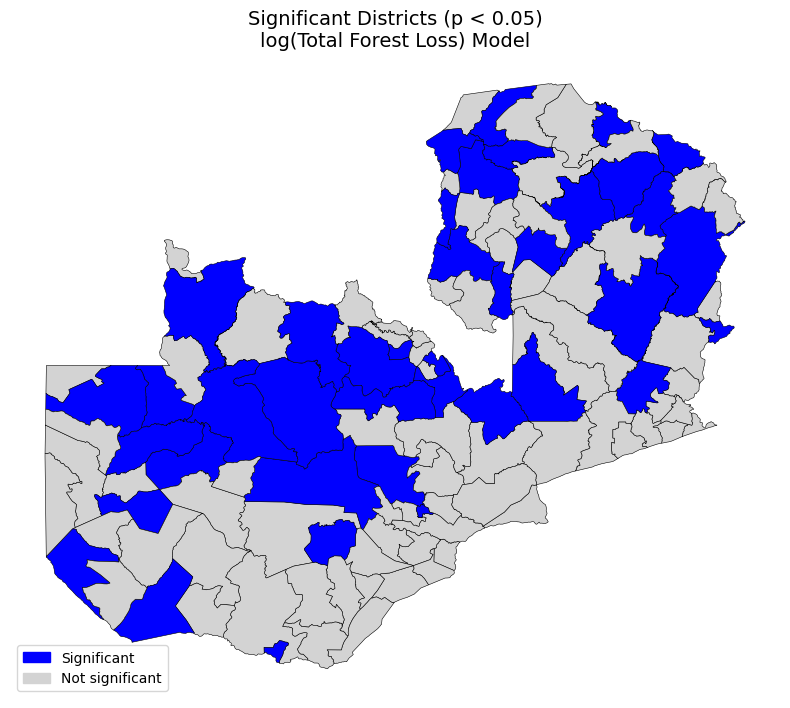

In [29]:
# map significant districts
districts_gdf = gpd.read_file('Data/district.shp')

# standardize district name
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()

# mark significant districts
districts_gdf['significant'] = districts_gdf['district'].isin(significant_district_list)

# create color column for plotting
districts_gdf['color'] = districts_gdf['significant'].map({True: 'blue', False: 'lightgray'})

# plot
fig, ax = plt.subplots(figsize=(8, 10))
districts_gdf.plot(ax=ax, color=districts_gdf['color'], edgecolor='black', linewidth=0.4)

ax.set_title("Significant Districts (p < 0.05)\nlog(Total Forest Loss) Model", fontsize=14)
ax.axis("off")

# Legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='blue', label='Significant'),
    mpatches.Patch(color='lightgray', label='Not significant')
]
ax.legend(handles=legend_handles, loc='lower left')

plt.tight_layout()
plt.show()

## All lags (1-5)

In [6]:
# log percent forest loss
results = []

for lag in range(1, 6):
    spei_col = f'mean_spei_lag{lag}'
    interaction = f'spei{lag}_x_popdens'
    
    # create interaction term dynamically
    cleaned[interaction] = cleaned[spei_col] * cleaned['pop_density_wi']

    # define and run model
    formula = f'log_percent_loss ~ {spei_col} + pop_density_wi + {interaction} + percent_forest_2000 + C(district)'
    model = smf.ols(formula=formula, data=cleaned).fit()

    # store summary stats
    results.append({
        'Lag': lag,
        'SPEI coef': model.params.get(spei_col, float('nan')),
        'SPEI pval': model.pvalues.get(spei_col, float('nan')),
        'Interaction coef': model.params.get(interaction, float('nan')),
        'Interaction pval': model.pvalues.get(interaction, float('nan')),
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic
    })

# convert results to table
results_df = pd.DataFrame(results)
results_df

,Lag,SPEI coef,SPEI pval,Interaction coef,Interaction pval,R-squared,Adj. R-squared,AIC,BIC
0,1,0.004421,7.157183e-01,0.009580,0.527977,0.418998,0.379026,713.587843,1074.069899
1,2,-0.048438,5.443119e-05,-0.013798,0.418747,0.428042,0.388692,696.268443,1056.750499
2,3,-0.050468,2.286749e-05,-0.005854,0.754789,0.428807,0.389510,694.789950,1055.272006
3,4,-0.083374,3.494699e-12,0.024236,0.107881,0.446099,0.407991,660.852910,1021.334966
4,5,-0.075449,1.425877e-09,0.016236,0.166868,0.439510,0.400949,673.907117,1034.389174


In [7]:
# log total forest loss

results = []

for lag in range(1, 6):
    spei_col = f'mean_spei_lag{lag}'
    interaction = f'spei{lag}_x_popdens'
    
    # create interaction term dynamically
    cleaned[interaction] = cleaned[spei_col] * cleaned['pop_density_wi']

    # define and run model
    formula = f'log_loss_m2 ~ {spei_col} + pop_density_wi + {interaction} + percent_forest_2000 + C(district)'
    model = smf.ols(formula=formula, data=cleaned).fit()

    # store summary stats
    results.append({
        'Lag': lag,
        'SPEI coef': model.params.get(spei_col, float('nan')),
        'SPEI pval': model.pvalues.get(spei_col, float('nan')),
        'Interaction coef': model.params.get(interaction, float('nan')),
        'Interaction pval': model.pvalues.get(interaction, float('nan')),
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic
    })

# convert results to table
results_df = pd.DataFrame(results)
results_df

,Lag,SPEI coef,SPEI pval,Interaction coef,Interaction pval,R-squared,Adj. R-squared,AIC,BIC
0,1,-0.017302,7.063871e-01,0.044371,0.439738,0.755994,0.739207,3651.441868,4011.923924
1,2,-0.158325,4.962448e-04,-0.048130,0.456895,0.758743,0.742145,3638.935168,3999.417225
2,3,-0.156420,5.325925e-04,0.008593,0.903834,0.758633,0.742027,3639.438795,3999.920852
3,4,-0.289543,1.871786e-10,0.078624,0.169671,0.765451,0.749314,3607.803496,3968.285552
4,5,-0.198760,2.754557e-05,0.020355,0.649966,0.759941,0.743425,3633.437568,3993.919624


## Plot

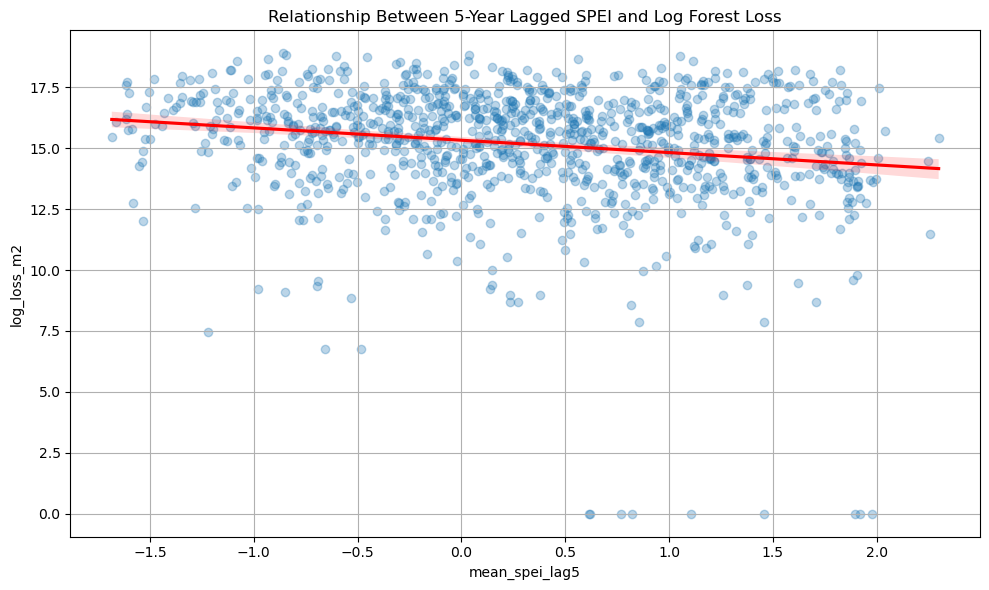

In [9]:
# overall scatterplot with regression line
plt.figure(figsize=(10,6))
sns.regplot(
    data=cleaned,
    x='mean_spei_lag5',
    y='log_loss_m2',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

plt.title('Relationship Between 5-Year Lagged SPEI and Log Forest Loss')
plt.xlabel('mean_spei_lag5')
plt.ylabel('log_loss_m2')
plt.grid(True)
plt.tight_layout()
plt.show()

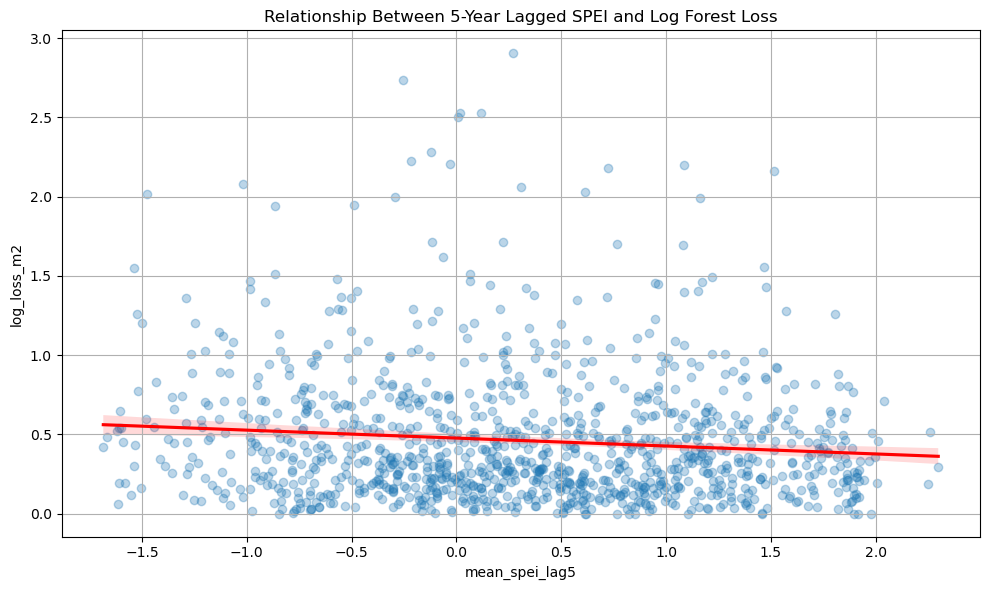

In [11]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=cleaned,
    x='mean_spei_lag5',
    y='log_percent_loss',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

plt.title('Relationship Between 5-Year Lagged SPEI and Log Forest Loss')
plt.xlabel('mean_spei_lag5')
plt.ylabel('log_loss_m2')
plt.grid(True)
plt.tight_layout()
plt.show()

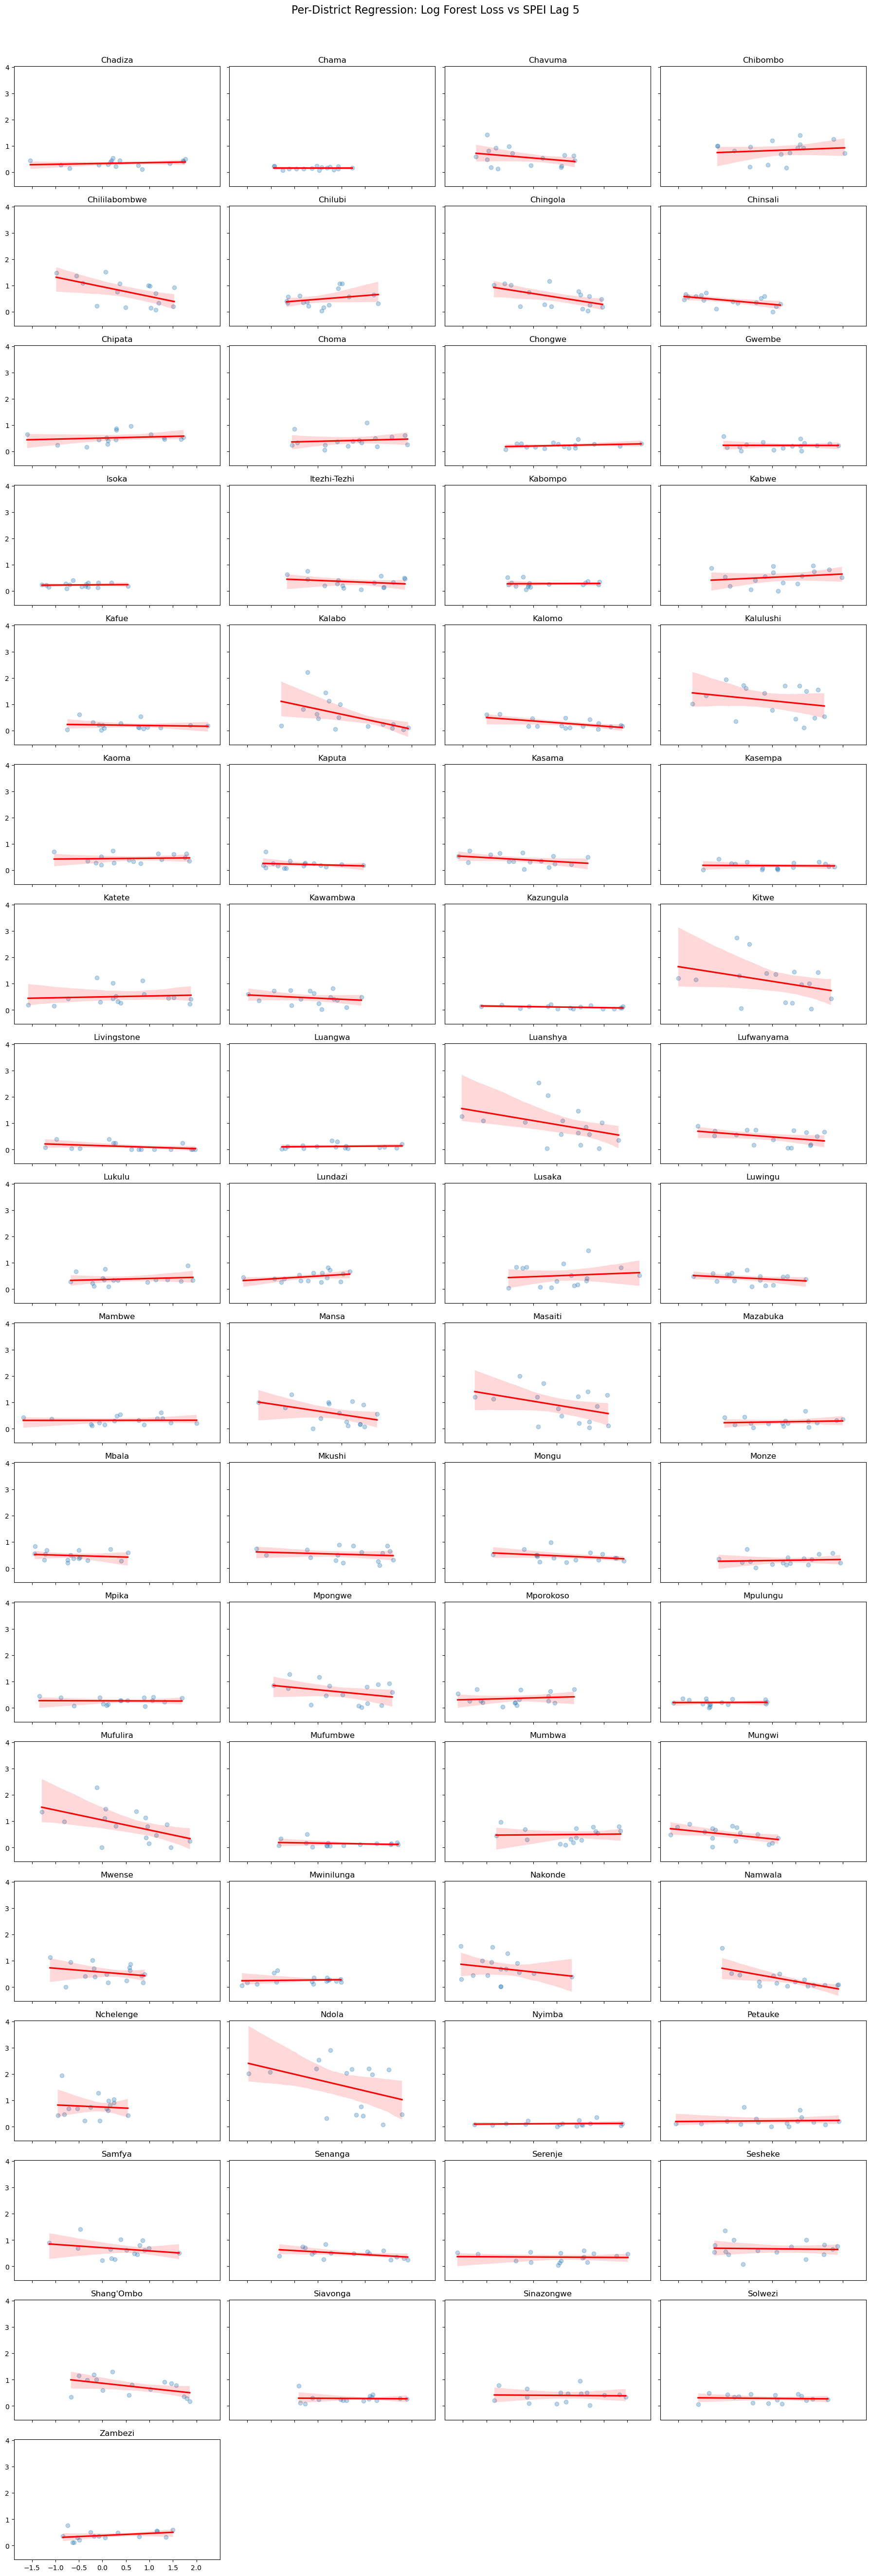

In [6]:
# per district regression lines

# get unique districts
districts = cleaned['district'].dropna().unique()

# set subplots
ncols = 4
nrows = (len(districts) + ncols - 1) // ncols

# set up subplot grid
fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 3), sharex=True, sharey=True)

# flatten axes array
axes = axes.flatten()

for i, district in enumerate(districts):
    ax = axes[i]
    subset = cleaned[cleaned['district'] == district]
    if subset['mean_spei_lag5'].nunique() < 2:
        continue

    sns.regplot(
        data=subset,
        x='mean_spei_lag5', 
        y='log_loss',
        ax=ax,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    ax.set_title(district)
    ax.set_ylabel('')
    ax.set_xlabel('')

# hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Per-District Regression: Log Forest Loss vs SPEI Lag 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

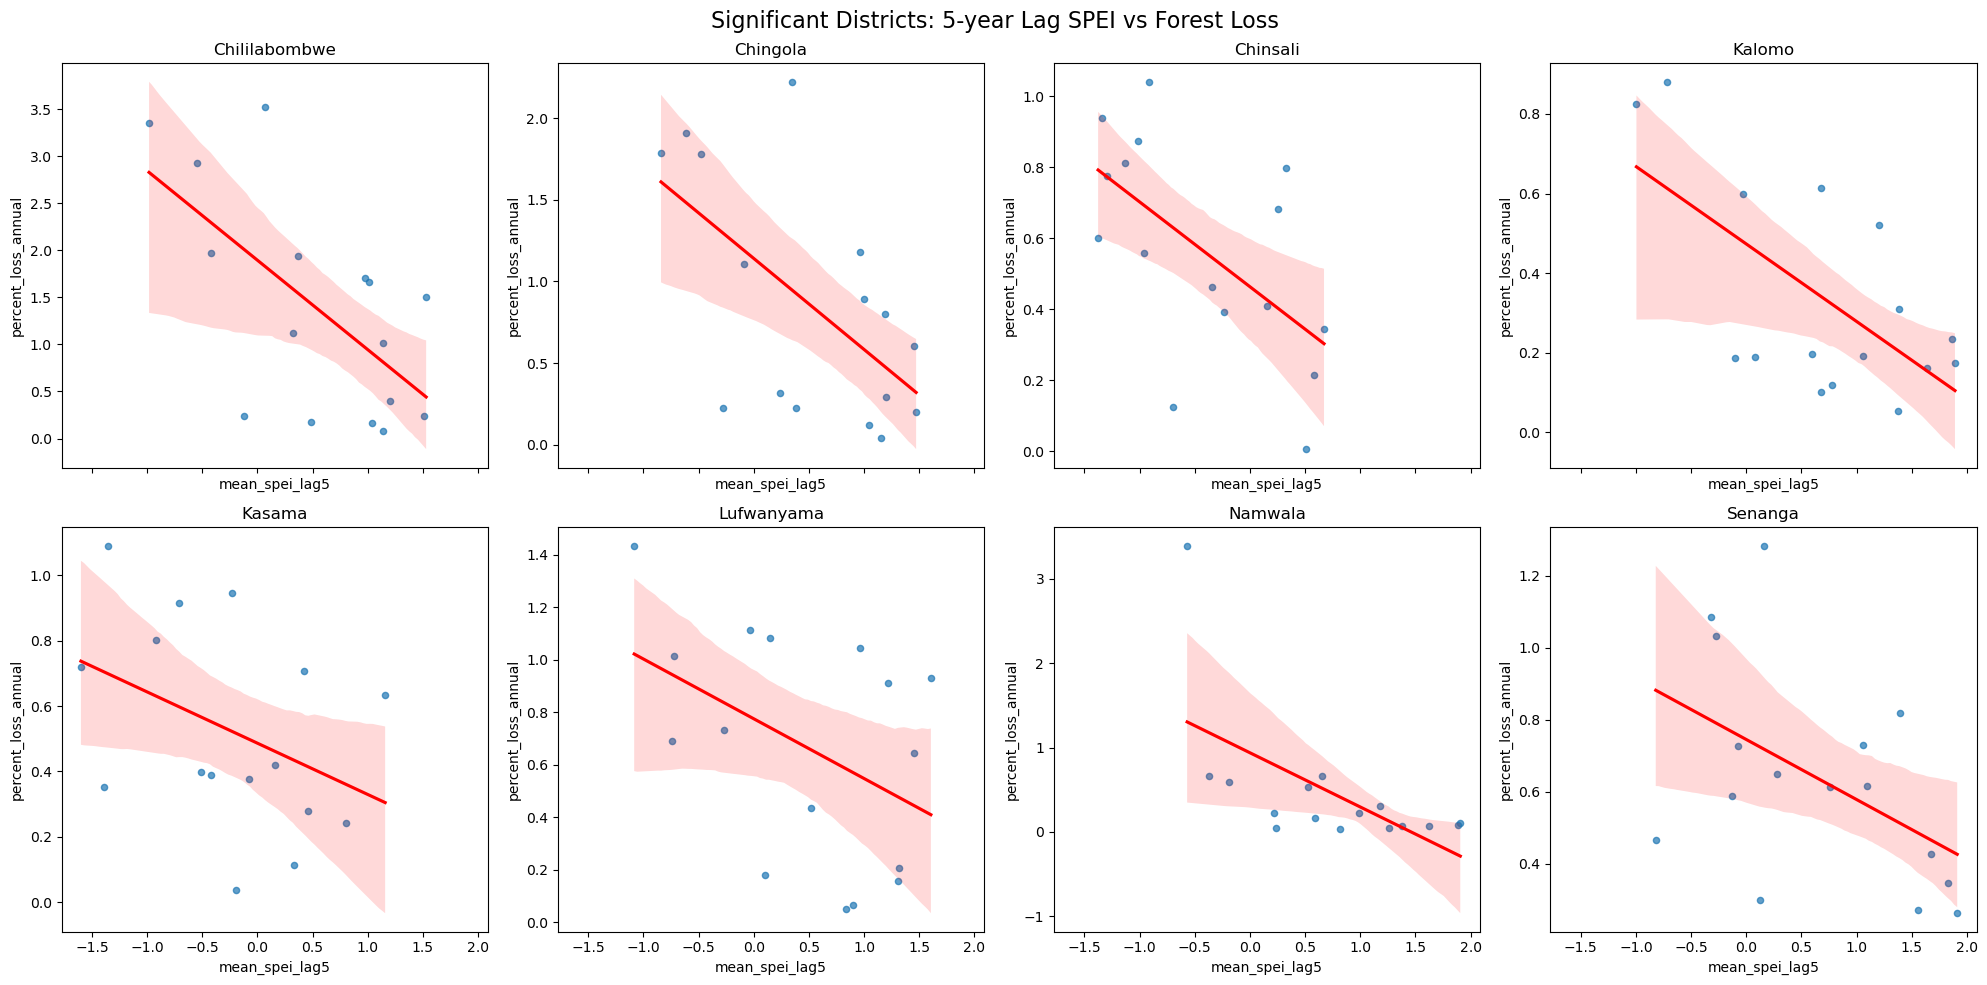

In [7]:
# statistically significant relationships between 5-yr lag SPEI and forest loss
significant_districts = [
    'Chililabombwe',
    'Chingola',
    'Chinsali',
    'Kalomo',
    'Kasama',
    'Lufwanyama',
    'Namwala',
    'Senanga'
]

subset = cleaned[cleaned['district'].isin(significant_districts)]

# set up figure and axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True, sharey=False)
axes = axes.flatten()

# plot each district
for i, district in enumerate(significant_districts):
    ax = axes[i]
    district_df = subset[subset['district'] == district]

    sns.regplot(
        data=district_df,
        x='mean_spei_lag5',
        y='percent_loss_annual',
        ax=ax,
        scatter_kws={'s': 20, 'alpha': 0.7},
        line_kws={'color': 'red'},
    )
    ax.set_title(district)


fig.suptitle('Significant Districts: 5-year Lag SPEI vs Forest Loss', fontsize=16)
plt.tight_layout()
plt.show()